# Lab Four: Wide and Deep Network Architectures


LJ Brown, Joe McGuire, Henry Warren, Mike Lefebvre, Xingming Qu


## 1. Business Understanding

In this lab, we will attempt to classify/predict the quality of a diamond through the use of deep learning. We will accomplish this by comparing and contrasting two different wide-and-deep learning architectures for this prediction task.

Having the ability predict diamond quality from secondary characteristics (from table data) within 98%+ accuracy will be of much use to both jewel wholesalers and retailers. 98%+ accuracy is required as diamonds are a luxury good with infrequent, high profit-margin sales. For this reason, the quality of at least 98 out of 100 diamonds must be predicted correctly.

### 1.2 Dataset Selection


Dataset: Diamonds

This classic dataset contains the prices and other attributes of almost 54,000 diamonds. It is in the form of table data with a number of characteristics including carat, cut, color, clarity, depth, price, and dimensions (x, y, z).

Reference: https://www.kaggle.com/shivam2503/diamonds

## 2 Preparation 

### 2.1 Define and prepare your class variables

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
warnings.simplefilter('ignore', DeprecationWarning)

# read original data 
 
df_orig_data = pd.read_csv('diamonds.csv')
df_orig_data.drop('Unnamed: 0',axis=1, inplace=True)
print(df_orig_data.info())
# print(df_orig_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None


Describe the classes distribution of the dataset

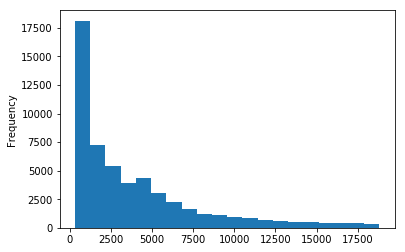

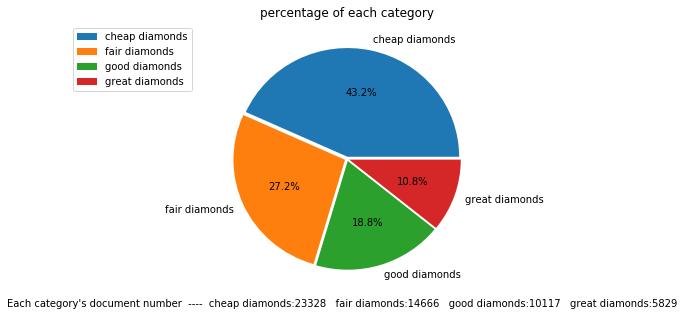

In [2]:
df_preprocessing=df_orig_data.sort_values(by='price')
plt.subplot(1,1,1)
df_preprocessing.price.plot.hist(bins=20)
max_price=df_preprocessing.price.max()

############################## Creat label for each classes ############################################ 
# 0--10%max==cheap diamonds(label 0)   10--30%max==fair diamonds(label 1)   
# 30--50%max==good diamonds(label 2)  50-100%max great diamonds(label 3)
import warnings
warnings.filterwarnings('ignore')

df_price=df_preprocessing.price
df_price[df_price<=max_price*0.10]=0
df_price[(df_price>max_price*0.10) & (df_price<=max_price*0.25)]=1
df_price[(df_price>max_price*0.25) & (df_price<=max_price*0.50)]=2
df_price[(df_price>max_price*0.50) & (df_price<=max_price*1)]=3
df_preprocessing['price']=df_price

################################# Draw a pie chart to show some infomation ################################
values=df_preprocessing['price'].value_counts()
plt.figure(figsize=(5,5))
explode=[0.02 for x in values]# Distance to center radius
name=['cheap diamonds','fair diamonds','good diamonds','great diamonds']
plt.pie(values,explode=explode,labels=name,autopct='%1.1f%%')# draw chart
plt.title('percentage of each category')#Title
plt.legend(loc='upper left', bbox_to_anchor=(-0.5, 1))
Xstring="Each category's document number  ----  "
it=0
for i in range(len(name)):
    Xstring=Xstring+name[i]+':'+str(values[i])+'   '

plt.xlabel(Xstring)
plt.show()

In [3]:
df_preprocessing.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,0,4.34,4.35,2.75


#### 2.1.1 Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [4]:
# define objects that can encode each variable as integer    
encoders = dict() 
categorical_headers = ['cut','color','clarity']

# train all encoders (special case the target 'income')
for col in categorical_headers:
    df_preprocessing[col] = df_preprocessing[col].str.strip()

    # integer encoded variables
    encoders[col] = LabelEncoder() # save the encoder
    df_preprocessing[col+'_int'] = encoders[col].fit_transform(df_preprocessing[col])


# scale the numeric, continuous variables
numeric_headers = ["carat", "depth", "table", "x", "y", "z"]

for col in numeric_headers:
    df_preprocessing[col] = df_preprocessing[col].astype(np.float)
    ss = StandardScaler()
    df_preprocessing[col] = ss.fit_transform(df_preprocessing[col].values.reshape(-1, 1))


In [44]:
encoders

{'cut': LabelEncoder(), 'color': LabelEncoder(), 'clarity': LabelEncoder()}

### Train/Test split <br>
We first used an 80/20 split to test the functionality of our network. We then used stratified K-fold cross validation because we have imbalanced classes in the test set and training set, as such, the proportion of classes should be consistent with the original data set. We decided on using 10 folds to get a large sampling of the performance of our algorithm on multiple subsamples, while still limiting the amount of computation time required for this project.

### Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance

In researching why accuracy is not a great evaluation metric, we discovered what's known as the "Accuracy Paradox," stating:

> Accuracy paradox for predictive analytics states that predictive models with a given level of accuracy may have greater predictive power than models with higher accuracy. <br/>
Source: https://en.wikipedia.org/wiki/Accuracy_paradox

The source is then perscriptive in its description, stating:
> It may be better to avoid the accuracy metric in favor of other metrics such as **precision** and **recall**. <br/>
Source: https://en.wikipedia.org/wiki/Accuracy_paradox

Given this paradox, accuracy may mistakenly perceived as a success metric, when a mix of precision and recall might be the better performance metric. Further research corroborated this hunch:
> Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.<br/>
Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

Therefore, we chose the f1_score method, with micro averaging, to evaluate our algorithm's generalization performance. The f1_score algorithm (with accuracy parameter set to "micro") operates as a weighted average of precision and recall that calculates metrics globally by counting the total true positives, false negatives, and false positives.<br/>
Source: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

We used stratified K-fold cross validation because we have imbalanced classes in the test set and training set, as such, the proportion of classes should be consistent with the original data set. We decided on using 10 folds to get a large sampling of the performance of our algorithm on multiple subsamples, while still limiting the amount of computation time required for this project.

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
categorical_headers_ints = [x+'_int' for x in categorical_headers]
feature_columns = categorical_headers_ints+numeric_headers

Y=df_preprocessing['price']
Y=np_utils.to_categorical(Y)
X=df_preprocessing

df_train, df_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)



Using TensorFlow backend.


#### 2.1.2 One Hot Encoding Categorical Data

In [6]:
# but we were dealing with the data incorrectly because we didn't one hot encode the 
#   categorical features
from sklearn.preprocessing import OneHotEncoder

def makeOneHot(Xtrain,Xtest,headers):
    ohe = OneHotEncoder()
    X_train_ohe = ohe.fit_transform(Xtrain[headers].values)
    X_test_ohe = ohe.transform(Xtest[headers].values)
    
    return X_train_ohe,X_test_ohe


X_train_ohe, X_test_ohe=makeOneHot(df_train,df_test,categorical_headers_ints)

### 2.2 Making Crossed Columns(will be implemented in 3.1.2)

color and clarity should be crossed because......(add some domain knowledge)
the implementation will be done in the modeling section

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras.layers import concatenate
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import metrics as mt
from keras import metrics

## 3 Modeling 
### 3.1 Create several(two) combined wide and deep networks to classify your data using Keras.

#### 3.1.1 Step One: Using Dense embeddings

In [8]:
X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values
embed_branches = []
X_ints_train = [] # keep track of inputs for each branch
X_ints_test = []# keep track of inputs for each branch
all_inputs = [] # this is what we will give to keras.Model inputs
all_branch_outputs = [] # this is where we will keep track of output of each branch

for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append( inputs ) # keep track of created inputs
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)

# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False, name='numeric'))
x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_2')(x) )

# merge the branches together
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=4,activation='softmax', name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

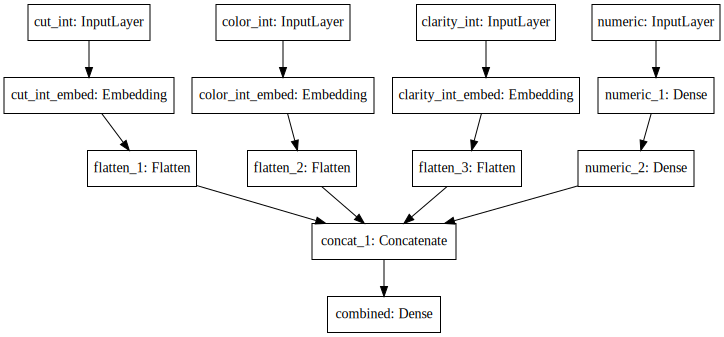

In [9]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [10]:
%%time

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_ints_train + [X_train_num], # create a list of inputs for embeddings
        y_train, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
43152/43152 [==============================] - 2s 38us/step - loss: 0.4517 - acc: 0.8324
Epoch 2/5
43152/43152 [==============================] - 1s 32us/step - loss: 0.2451 - acc: 0.9087
Epoch 3/5
43152/43152 [==============================] - 1s 32us/step - loss: 0.2052 - acc: 0.9231
Epoch 4/5
43152/43152 [==============================] - 1s 33us/step - loss: 0.1884 - acc: 0.9273
Epoch 5/5
43152/43152 [==============================] - 2s 36us/step - loss: 0.1792 - acc: 0.9302
Wall time: 7.88 s


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
yhat = np.round(model.predict(X_ints_test + [X_test_num]))
# print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))
f1_score(y_test,yhat,average='micro')

0.9314979606970708

#### 3.1.2 Step Two: Making Crossed Columns

In [12]:


cross_columns = [['cut','color'],
                 ['color', 'clarity'],
                 [ 'clarity','cut']
                 ]

# we will create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for cols in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    
    # 3. save encodings in a list for each branch
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories in the crossing
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the crossed encoding
    inputs = Input(shape=(1,),dtype='int32',name='_'.join(cols))
    all_inputs.append(inputs) # save this as input for the keras.Model
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name='_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x) # save for concatenating later
    
# merge the branches together
final_branch = concatenate(all_branch_outputs)
# add a layer after merging
final_branch = Dense(units=4,activation='softmax',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

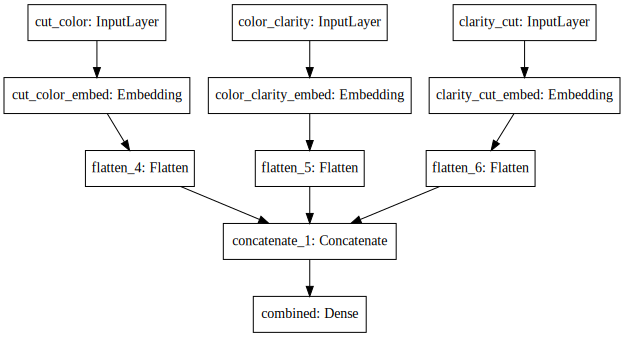

In [13]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [14]:
%%time

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_ints_train,
        y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
43152/43152 [==============================] - 1s 32us/step - loss: 1.2107 - acc: 0.4710
Epoch 2/10
43152/43152 [==============================] - 1s 27us/step - loss: 1.1748 - acc: 0.4904
Epoch 3/10
43152/43152 [==============================] - 1s 30us/step - loss: 1.1724 - acc: 0.4898
Epoch 4/10
43152/43152 [==============================] - 1s 29us/step - loss: 1.1717 - acc: 0.4898
Epoch 5/10
43152/43152 [==============================] - 1s 29us/step - loss: 1.1713 - acc: 0.4898
Epoch 6/10
43152/43152 [==============================] - 1s 31us/step - loss: 1.1710 - acc: 0.4899
Epoch 7/10
43152/43152 [==============================] - 1s 28us/step - loss: 1.1710 - acc: 0.4905
Epoch 8/10
43152/43152 [==============================] - 1s 34us/step - loss: 1.1708 - acc: 0.4904
Epoch 9/10
43152/43152 [==============================] - 1s 29us/step - loss: 1.1709 - acc: 0.4908
Epoch 10/10
43152/43152 [==============================] - 1s 25us/step - loss: 1.1708 - acc: 0.4902

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
yhat = np.round(model.predict(X_ints_test))
# print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))
f1_score(y_test,yhat,average='micro')

0.34698089341588445

#### 3.1.3 Step Three (Final): Combining Crossed Linear Classifier and Deep Embeddings

Using one wide and deep networks to classify

In [16]:

embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=4,activation='softmax',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)



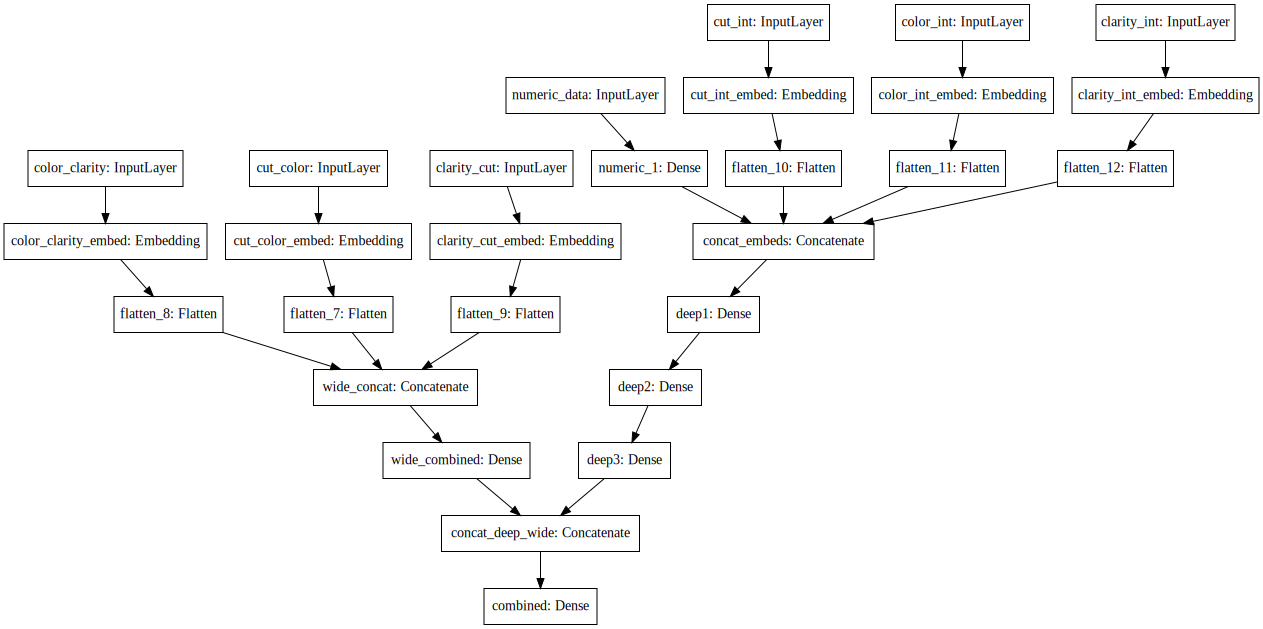

In [17]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [18]:
%%time

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))

Train on 43152 samples, validate on 10788 samples
Epoch 1/10
43152/43152 [==============================] - 3s 74us/step - loss: 0.2999 - acc: 0.8788 - val_loss: 0.1753 - val_acc: 0.9304
Epoch 2/10
43152/43152 [==============================] - 2s 52us/step - loss: 0.1743 - acc: 0.9306 - val_loss: 0.1694 - val_acc: 0.9319
Epoch 3/10
43152/43152 [==============================] - 2s 52us/step - loss: 0.1661 - acc: 0.9345 - val_loss: 0.1574 - val_acc: 0.9359
Epoch 4/10
43152/43152 [==============================] - 2s 56us/step - loss: 0.1622 - acc: 0.9352 - val_loss: 0.1600 - val_acc: 0.9376
Epoch 5/10
43152/43152 [==============================] - 2s 44us/step - loss: 0.1580 - acc: 0.9378 - val_loss: 0.1579 - val_acc: 0.9366
Epoch 6/10
43152/43152 [==============================] - 2s 46us/step - loss: 0.1555 - acc: 0.9377 - val_loss: 0.1483 - val_acc: 0.9414
Epoch 7/10
43152/43152 [==============================] - 2s 45us/step - loss: 0.1532 - acc: 0.9399 - val_loss: 0.1541 - val_acc

Using two wide and deep networks to classify

In [19]:
def creatCombinedModel(df_train,df_test):
# we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    wide_branch2 = concatenate(all_wide_branch_outputs, name='wide_concat-2')
    wide_branch2 = Dense(units=1,activation='sigmoid',name='wide_combined-2')(wide_branch2)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    # deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

    deep_branch2 = concatenate(all_deep_branch_outputs,name='concat_embeds-2')
    deep_branch2 = Dense(units=60,activation='relu', name='deep1-2')(deep_branch2)
    deep_branch2 = Dense(units=30,activation='relu', name='deep2-2')(deep_branch2)


    final_branch1 = concatenate([wide_branch, deep_branch],name='concat_deep_wide1')


    final_branch2 = concatenate([wide_branch2, deep_branch2],name='concat_deep_wide2')


    final_branch3 = concatenate([final_branch1, final_branch2],name='concat_deep_wide_final')
    final_branch3= Dense(units=4,activation='softmax',name='combined-final')(final_branch3)

    model2 = Model(inputs=all_inputs, outputs=final_branch3)
    return model2,X_ints_train,X_ints_test



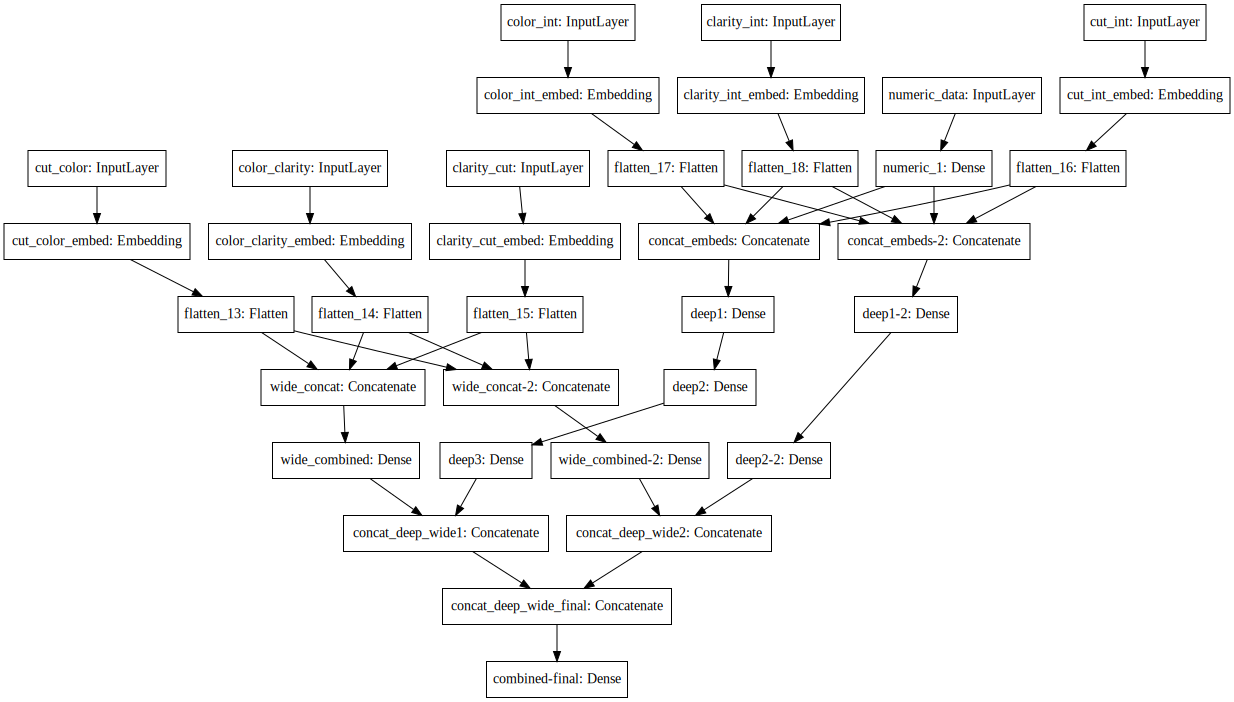

In [20]:
model2,_,_=creatCombinedModel(df_train,df_test)
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [21]:
%%time

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history_two_combine = model2.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))

Train on 43152 samples, validate on 10788 samples
Epoch 1/10
43152/43152 [==============================] - 4s 94us/step - loss: 0.2774 - acc: 0.8948 - val_loss: 0.1788 - val_acc: 0.9279
Epoch 2/10
43152/43152 [==============================] - 3s 65us/step - loss: 0.1729 - acc: 0.9303 - val_loss: 0.1604 - val_acc: 0.9341
Epoch 3/10
43152/43152 [==============================] - 3s 67us/step - loss: 0.1631 - acc: 0.9342 - val_loss: 0.1536 - val_acc: 0.9402
Epoch 4/10
43152/43152 [==============================] - 3s 64us/step - loss: 0.1583 - acc: 0.9372 - val_loss: 0.1591 - val_acc: 0.9373
Epoch 5/10
43152/43152 [==============================] - 2s 53us/step - loss: 0.1546 - acc: 0.9383 - val_loss: 0.1488 - val_acc: 0.9400
Epoch 6/10
43152/43152 [==============================] - 3s 67us/step - loss: 0.1516 - acc: 0.9399 - val_loss: 0.1513 - val_acc: 0.9390
Epoch 7/10
43152/43152 [==============================] - 3s 75us/step - loss: 0.1506 - acc: 0.9392 - val_loss: 0.1504 - val_acc

Visualize the performance of the network on the training data and validation data in the same plot versus the training 

Text(0.5,0,'epochs')

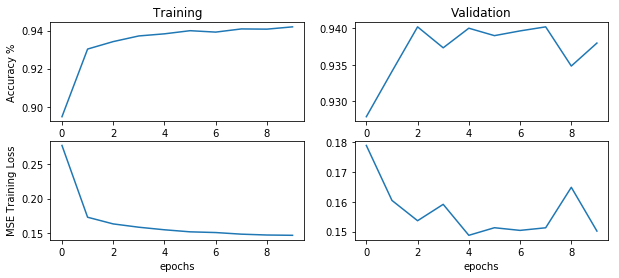

In [22]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history_two_combine.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history_two_combine.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_two_combine.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_two_combine.history['val_loss'])
plt.xlabel('epochs')

### 3.2 Investigate generalization performance by altering the number of layers in the deep branch of the network.

In [23]:
##################################### First model###########################################
# number of layers in the deep branch of the network.
# first network (40 20 10)    second(60 30)


def creatCombinedModelFirst(df_train,df_test):
# we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    wide_branch2 = concatenate(all_wide_branch_outputs, name='wide_concat-2')
    wide_branch2 = Dense(units=1,activation='sigmoid',name='wide_combined-2')(wide_branch2)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=40,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=20,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    # deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

    deep_branch2 = concatenate(all_deep_branch_outputs,name='concat_embeds-2')
    deep_branch2 = Dense(units=60,activation='relu', name='deep1-2')(deep_branch2)
    deep_branch2 = Dense(units=30,activation='relu', name='deep2-2')(deep_branch2)
#     deep_branch2 = Dense(units=15,activation='relu', name='deep2-3')(deep_branch2)


    final_branch1 = concatenate([wide_branch, deep_branch],name='concat_deep_wide1')


    final_branch2 = concatenate([wide_branch2, deep_branch2],name='concat_deep_wide2')


    final_branch3 = concatenate([final_branch1, final_branch2],name='concat_deep_wide_final')
    final_branch3= Dense(units=4,activation='softmax',name='combined-final')(final_branch3)

    model2 = Model(inputs=all_inputs, outputs=final_branch3)
    return model2,X_ints_train,X_ints_test



In [24]:
##################################### Second model###########################################
# number of layers in the deep branch of the network.
# first network (40,)    second(60,)


def creatCombinedModelSecond(df_train,df_test):
# we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    wide_branch2 = concatenate(all_wide_branch_outputs, name='wide_concat-2')
    wide_branch2 = Dense(units=1,activation='sigmoid',name='wide_combined-2')(wide_branch2)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=40,activation='relu', name='deep1')(deep_branch)
#     deep_branch = Dense(units=20,activation='relu', name='deep2')(deep_branch)
#     deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    # deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

    deep_branch2 = concatenate(all_deep_branch_outputs,name='concat_embeds-2')
    deep_branch2 = Dense(units=60,activation='relu', name='deep1-2')(deep_branch2)
#     deep_branch2 = Dense(units=30,activation='relu', name='deep2-2')(deep_branch2)


    final_branch1 = concatenate([wide_branch, deep_branch],name='concat_deep_wide1')


    final_branch2 = concatenate([wide_branch2, deep_branch2],name='concat_deep_wide2')


    final_branch3 = concatenate([final_branch1, final_branch2],name='concat_deep_wide_final')
    final_branch3= Dense(units=4,activation='softmax',name='combined-final')(final_branch3)

    model2 = Model(inputs=all_inputs, outputs=final_branch3)
    return model2,X_ints_train,X_ints_test



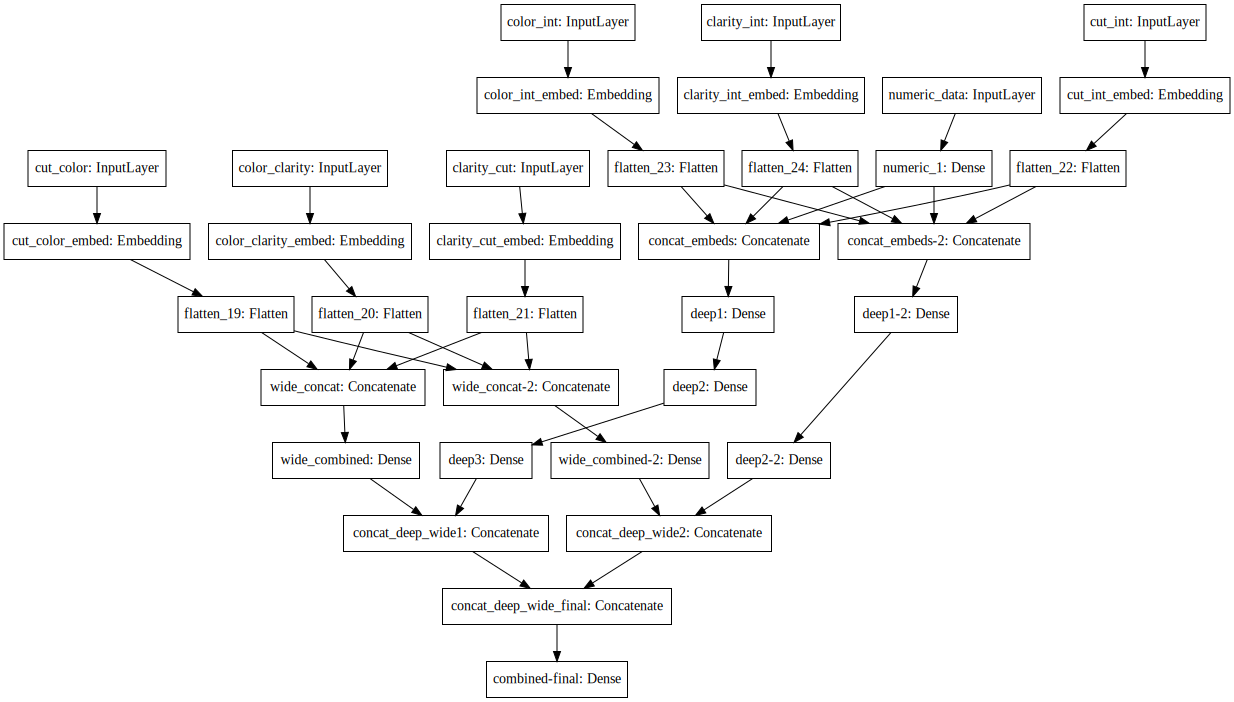

In [25]:
modelfirst,_,_=creatCombinedModelFirst(df_train,df_test)
SVG(model_to_dot(modelfirst).create(prog='dot', format='svg'))



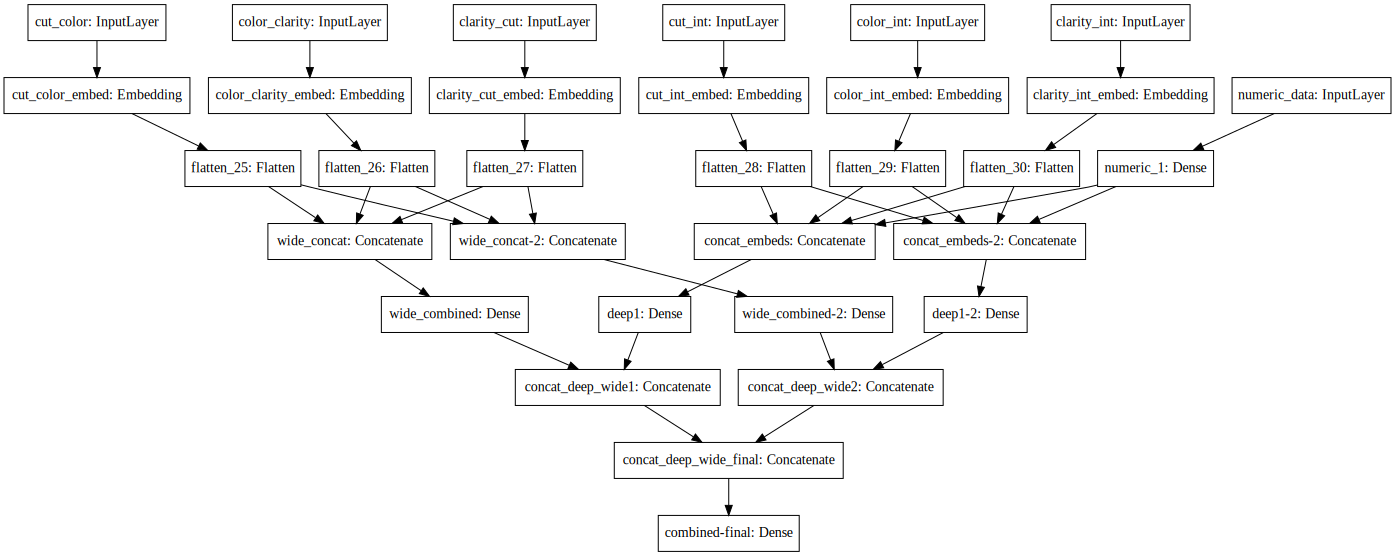

In [26]:
modelsecond,_,_=creatCombinedModelSecond(df_train,df_test)
SVG(model_to_dot(modelsecond).create(prog='dot', format='svg'))

#### 3.2.1 Use the method of cross validation and evaluation metric

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp
K_fold=5
def ourStratifiedKFold(num):
    cv = StratifiedShuffleSplit(n_splits=K_fold,test_size=0.2)
    fold=cv.split(X,Y)
    X_train_Stratified = []
    X_test_Stratified = []
    y_train_Stratified = []
    y_test_Stratified = []

    X_train_Stratified_num=[]
    X_test_Stratified_num=[]

    for train_index, test_index in fold:
        X_train_Stratified.append(X.iloc[train_index])
        X_test_Stratified.append(X.iloc[test_index])
        y_train_Stratified.append(Y[train_index])
        y_test_Stratified.append(Y[test_index])

        X_train_Stratified_num.append(X_train_Stratified[-1][numeric_headers])
        X_test_Stratified_num.append(X_test_Stratified[-1][numeric_headers])

    score=[]
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    plt.figure()

    for i in range(len(X_train_Stratified)):
        print('fold',i)

        if num==1:
            model,X_ints_train,X_ints_test = creatCombinedModelFirst(X_train_Stratified[i],X_test_Stratified[i])
        if num==2:
            model,X_ints_train,X_ints_test = creatCombinedModelSecond(X_train_Stratified[i],X_test_Stratified[i])
            
        model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # lets also add the history variable to see how we are doing
    # and lets add a validation set to keep track of our progress
        history=model.fit(X_ints_train+ [X_train_Stratified_num[i]],
                        y_train_Stratified[i], 
                        epochs=5, 
                        batch_size=32, 
                        verbose=0, 
                          )

        yhat =np.round(model.predict(X_ints_test+ [X_test_Stratified_num[i]]))
        score.append(f1_score(y_test_Stratified[i],yhat,average='micro'))
        

        y_score =yhat
        y_test=y_test_Stratified[i]

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(4):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



        plt.plot(fpr[2], tpr[2],
                 lw=1, label='fold %d ROC curve (area = %0.2f)' % (i+1,roc_auc[2]))

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
    plt.show()
    return score,np.mean(score)
    

fold 0
fold 1
fold 2
fold 3
fold 4


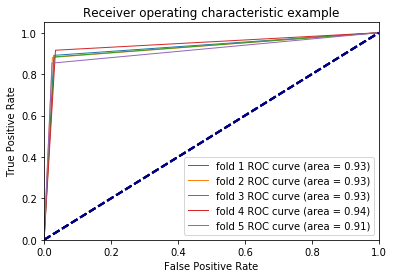

Wall time: 1min 18s


In [28]:
%%time

first_score,first_mean=ourStratifiedKFold(1)

fold 0
fold 1
fold 2
fold 3
fold 4


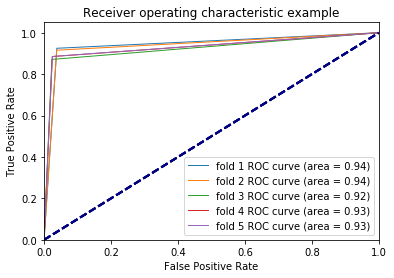

In [29]:
second_score,second_mean=ourStratifiedKFold(2)

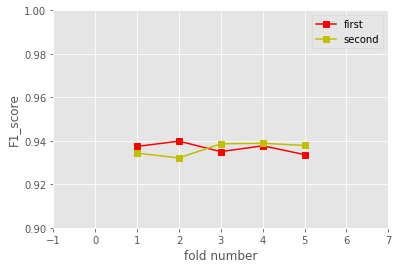

mean f1 of first: 0.9367346465816917
mean f1 of second: 0.9363714395477196


In [30]:
plt.style.use('ggplot')
length=range(1,K_fold+1)
plt.plot(length,first_score,'s-',color = 'r',label="first")
plt.plot(length,second_score,'s-',color = 'y',label="second")

plt.xlabel("fold number")
plt.ylabel("F1_score")
plt.legend(loc = "best")

plt.ylim(0.9, 1)
plt.xlim(-1, K_fold+2)
plt.show()
print('mean f1 of first:',first_mean)
print('mean f1 of second:',second_mean)


### 3.3 ompare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP).


fold 0
fold 1
fold 2
fold 3
fold 4


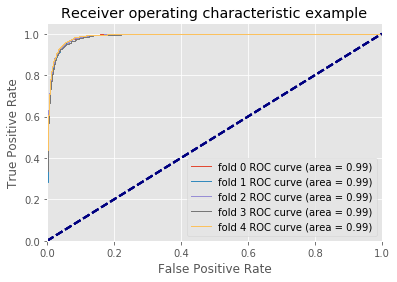

Wall time: 8.67 s


In [31]:
%%time


category=['cut_int','color_int','clarity_int']
cv = StratifiedShuffleSplit(n_splits=K_fold,test_size=0.2)
fold=cv.split(X,Y)
X_train_Stratified = []
X_test_Stratified = []
y_train_Stratified = []
y_test_Stratified = []

X_train_Stratified_num=[]
X_test_Stratified_num=[]

for train_index, test_index in fold:
    X_train_Stratified.append(X.iloc[train_index])
    X_test_Stratified.append(X.iloc[test_index])
    y_train_Stratified.append(Y[train_index])
    y_test_Stratified.append(Y[test_index])

    X_train_Stratified_num.append(X_train_Stratified[-1][numeric_headers])
    X_test_Stratified_num.append(X_test_Stratified[-1][numeric_headers])
    

mlp_score=[]
#using one hot encoding for category data and plus numeric as feature
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
plt.figure()
for i in range(len(X_train_Stratified)):
    print('fold',i)
    X_train_ohe, X_test_ohe=makeOneHot(X_train_Stratified[i],X_test_Stratified[i],category)
    
    X_train=np.hstack((X_train_ohe.toarray(),  X_train_Stratified_num[i].values))
    X_test=np.hstack((X_test_ohe.toarray(),  X_test_Stratified_num[i].values))
    
    clf = MLPClassifier(hidden_layer_sizes=(60,30,15),max_iter=5)
    clf.fit(X_train,y_train_Stratified[i])
    
    yhat = clf.predict(X_test)
    mlp_score.append(f1_score(y_test_Stratified[i],yhat,average='micro'))
    
    
    y_score =clf.predict_proba(X_test)
    y_test=y_test_Stratified[i]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for j in range(4):
        fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    
    
    plt.plot(fpr[2], tpr[2],
             lw=1, label='fold %d ROC curve (area = %0.2f)' % (i,roc_auc[2]))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
plt.show()

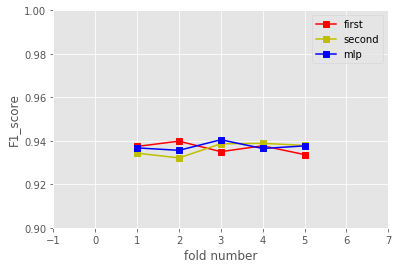

mean f1 of first: 0.9367346465816917
mean f1 of second: 0.9363714395477196
mean f1 of mlp: 0.9374016704708531


In [32]:
plt.style.use('ggplot')
length=range(1,K_fold+1)
plt.plot(length,first_score,'s-',color = 'r',label="first")
plt.plot(length,second_score,'s-',color = 'y',label="second")
plt.plot(length,mlp_score,'s-',color = 'b',label="mlp")

plt.xlabel("fold number")
plt.ylabel("F1_score")
plt.legend(loc = "best")

plt.ylim(0.9, 1)
plt.xlim(-1, K_fold+2)
plt.show()
print('mean f1 of first:',first_mean)
print('mean f1 of second:',second_mean)
print('mean f1 of mlp:',np.mean(mlp_score))


## 4 Exceptional Work
Capture the embedding weights from the deep network and (if needed) perform t-SNE clustering on the output of these embedding layers.

In [43]:
model2.get_layer('clarity_int_embed').get_weights()

[array([[-0.74718446,  0.88750106],
        [ 0.34608117, -0.34749734],
        [-0.0210192 ,  0.1310641 ],
        [-0.34015983,  0.20488073],
        [ 0.08227906, -0.1331478 ],
        [ 0.09736864,  0.00423342],
        [ 0.30015633, -0.30782136],
        [ 0.1283722 , -0.32419246]], dtype=float32)]

In [61]:
clarityEncoder=encoders['color']
clarityEncoder.classes_

array(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object)

In [62]:
clarityEncoder.transform(clarityEncoder.classes_)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [67]:
import matplotlib.pyplot as plt

def plot_embedding(model, model_label_encoder, layer_name):
    label_encoder = model_label_encoder[layer_name]
    layer_weights_name = '%s_int_embed' % layer_name
    
    N = len(label_encoder.classes_)
    data = np.random.random((N, 4))
    #emeding_vectors = model2.get_layer('color_int_embed').get_weights()[0]
    emeding_vectors = model.get_layer(layer_weights_name).get_weights()[0]
    #labels = ['point{0}'.format(i) for i in range(N)]
    labels = label_encoder.classes_

    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(
        emeding_vectors[:, 0], emeding_vectors[:, 1], marker='o', c=data[:, 2], s=100,
        cmap=plt.get_cmap('Spectral'))

    for label, x, y in zip(labels, emeding_vectors[:, 0], emeding_vectors[:, 1]):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.show()
    
    



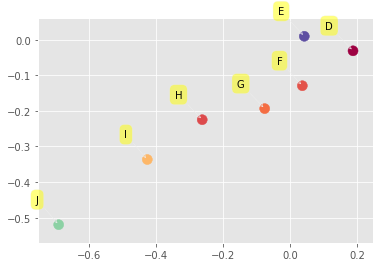

In [68]:
plot_embedding(model2,encoders,'color')

 D being the best and J the worst (please add detail explanation   Visualize and explain any clusters in the data.
 )

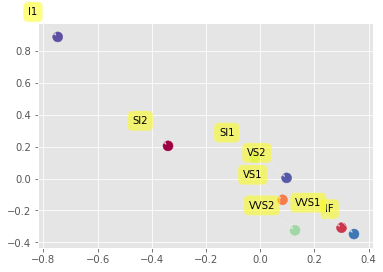

In [69]:
plot_embedding(model2,encoders,'clarity')

clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

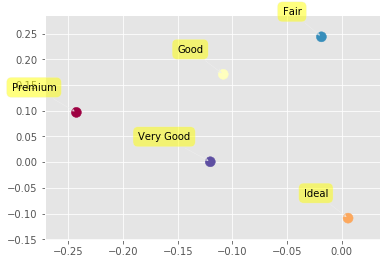

In [70]:
plot_embedding(model2,encoders,'cut')

cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)